# STATS 199 Notebook


In [1]:
from sklearn.decomposition import LatentDirichletAllocation, NMF, PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from utils import get_logger, get_now
import pandas, sys, json, datetime, re, pickle
import numpy as np

def load_dataset(filename, sample=None):
    try:
        df = pandas.read_csv(filename)
        if sample:
            df = df.sample(sample)
        return df
    except FileNotFoundError:
        print("File not found!")
        return None
    except Exception as e:
        print(str(e))
        return None



In [ ]:
""" Although the focus has shifted to all titles, this is still a useful function
to have in the toolbox.
"""
def filter_since(year=2017, day=20, month=1):
    filenames = ["article_data/articles1.csv", "article_data/articles2.csv", "article_data/articles3.csv"]
    df = pandas.DataFrame()
    for filename in filenames:
        df = df.append(pandas.read_csv(filename))

    inauguration = datetime.datetime(day=day, month=month, year=year)
    df.date = pandas.to_datetime(df.date, yearfirst=True)
    df = df.loc[df.date > inauguration]
    df.to_csv("since_inaug.csv")

In [41]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, KernelPCA
from nltk.stem.snowball import EnglishStemmer
from sklearn.preprocessing import RobustScaler, scale
stemmer = EnglishStemmer()

""" Stem words. 
Tokenizes on whitespace after removing consecutive (whitespace) characters.
"""
def stem_words(sentence):
    sentence = re.sub("[\s]+", u" ", sentence)
    words = [stemmer.stem(word) for word in sentence.split(" ")]
    return " ".join(words)
    
def run_kmeans(filename, n_topics, ngram_range, **kwargs):
    stemmer = EnglishStemmer()
    data = load_dataset(filename)
    data.dropna(subset=['content', 'title'], inplace=True)
    vec = TfidfVectorizer(stop_words='english', ngram_range=ngram_range, max_features=1500)
    print("here1")
    titles = data['title'].apply(lambda x: stem_words(re.sub("( - Breitbart)|([\s]+$)|(^[\s]+)|(as it happened)|(\u2019)|(\u2018)|(\u2013)|(\u201c)|(\u201d)|(\u00a0)|( - The New York Times)", " ", x)))
    titles = titles.apply(lambda x: re.sub("[\s]+", u" ", x))
    transformed_docs = vec.fit_transform(titles)
    print("here2")
    # Convert to array, RobustScaler does not work on sparse matricies
    transformed_docs = transformed_docs
    scaled_docs = scale(transformed_docs, with_mean=False)
    topic_model = KMeans(n_clusters=n_topics, n_jobs=-1)
    print("here3")
    clusters = topic_model.fit_predict(scaled_docs)
    clusters_labels = [{'index': index.item(), 'cluster_label': cluster_label.item(), 'title': title , 'publication': publication} for index,cluster_label,title, publication in zip(np.arange(0, clusters.shape[0]), clusters, titles, data['publication'])]
    cluster_df = pandas.DataFrame(clusters_labels)
    cluster_df.to_csv("clusters.csv")
    components = get_pc(cluster_df, n_topics=n_topics, **kwargs)
    return components
    #cluster_df.to_csv("clusters.csv")


***
## Principal Component Analysis
<br>
Next, we decompose the publication by cluster column vectors with Principal Component Analysis. This is a form of dimensionality reduction, and finds the lower-dimensional (given by `n_components`) subspace with the greatest variance. This means that we can reduce the dimensonality to either 2D or 3D, and plot it.

In [122]:
from sklearn.decomposition import PCA

def get_pc(df, n_topics, n_components=3, **kwargs):

    publications = pandas.unique(df['publication'])
    print(publications.shape)
    init_matrix = np.zeros((publications.shape[0], n_topics))
    print(init_matrix.shape)

    index_converter = {}
    for i,publication in enumerate(publications):
        index_converter[publication] = i

    for i,j in enumerate(df.index):
        cluster = df.loc[j, 'cluster_label']
        init_matrix[index_converter[df.loc[j, 'publication']], cluster] += 1

    pca_model = PCA(n_components=n_components, whiten=True, svd_solver="randomized", **kwargs)
    components = pca_model.fit_transform(init_matrix)
        
    return components, publications

In [ ]:
import pickle,pandas
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from matplotlib.pyplot import plot #, show

df = pandas.read_csv("clusters.csv")
matrix, publications = get_pc(df, 40)
daf = pandas.DataFrame(matrix, columns=['first', 'second', 'third'])    

In [124]:
import pandas, rpy2;
import rpy2.robjects.numpy2ri, rpy2.robjects.pandas2ri;
rpy2.robjects.numpy2ri.activate();
rpy2.robjects.pandas2ri.activate();


rpy2.robjects.r['options'](warn=-1)

%reload_ext rpy2.ipython



In [125]:
%R -i publications -o publications
%R -i daf -o daf

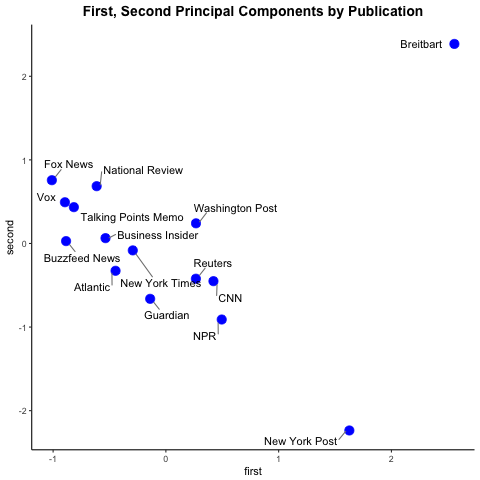

In [126]:
%%R library(ggplot2); library(dplyr); library(ggrepel); library(plotly);
daf$publications = publications
graph = daf %>% ggplot() + aes(x=first, y=second) + geom_point(size=4, shape=19, color="blue") + geom_text_repel(aes(label=publications),box.padding   = 0.35, 
                  point.padding = 0.5,
                  segment.color = 'grey50') + theme_classic() + ggtitle('First, Second Principal Components by Publication') + theme(plot.title=element_text(hjust=0.5, size=14, face="bold"))


print(graph)

plot_ly(daf, x=~first, y=~second, z=~third, text= ~ as.factor(publications)) %>% add_markers()